In [1]:
# Core scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import sys
import os
import random

# Statistical and ML utilities
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA

# Online learning framework (River)
from river import preprocessing, linear_model, optim, metrics
from river.datasets import synth

# Drift detection and adaptation modules
sys.path.insert(0, os.path.abspath('../backup'))
from shape_dd import shape, shape_adaptive_v2
from gen_data import gen_random

sys.path.insert(0, os.path.abspath('../../drift-monitoring'))
from drift_type_classifier import classify_drift_at_detection, DriftTypeConfig
from adaptation_strategies import (
    adapt_sudden_drift, adapt_incremental_drift, adapt_gradual_drift,
    adapt_recurrent_drift, adapt_blip_drift
)


In [ ]:
# Visualization settings (publication quality)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Data stream configuration
STREAM_SIZE = 10000              # Total number of samples
DRIFT_POSITION = 5000           # Single sudden drift at midpoint
RANDOM_SEED = random.randint(0, 1000000)          

# Initial training configuration
INITIAL_TRAINING_SIZE = 500     # Samples for initial model training (pre-drift)
TRAINING_WARMUP = 100           # Additional samples before starting evaluation

# Drift detection parameters (ShapeDD - Adaptive)
BUFFER_SIZE = 1000                # Detection window size
CHUNK_SIZE = 150                  # Detection frequency
DRIFT_ALPHA = 0.05               # Significance level
SHAPE_L1 = 50                    # ShapeDD parameter: reference window half-size
SHAPE_L2 = 150                   # ShapeDD parameter: MMD window size
SHAPE_N_PERM = 2500              # Number of permutations
SHAPE_SENSITIVITY = 'none'       # Sensitivity mode for shape_adaptive_v2

# Model evaluation parameters
PREQUENTIAL_WINDOW = 100        # Sliding window for accuracy calculation

# Adaptation strategy parameters
ADAPTATION_DELAY = 50           # Samples to wait after detection before adapting
ADAPTATION_WINDOW = 800        # Samples used for model retraining

# Drift type classification configuration
drift_type_config = DriftTypeConfig(
    w_ref=250,                  # Reference window size
    w_basic=100,                 # Basic analysis window
    sudden_len_thresh=250       # Threshold for sudden drift classification
)


Configuration loaded:
  Detection: shape_adaptive(sensitivity='none')
  Buffer=1000, Chunk=150, α=0.05


In [3]:
# DATASET CATALOG AND MULTI-DRIFT GENERATION

import sys
import os
sys.path.insert(0, os.path.abspath('../backup'))
from gen_data import gen_random
from river.datasets import synth


DATASET_CATALOG = {
    'standard_sea': {
        'enabled': True,
        'name': 'SEA Standard',
        'n_drift_events': 2,
        'params': {}
    },
    'enhanced_sea': {
        'enabled': True,
        'name': 'SEA Enhanced',
        'n_drift_events': 2,
        'params': {
            'scale_factors': (1.8, 1.5, 2.0),
            'shift_amounts': (5.0, 4.0, 8.0)
        }
    },
    'stagger': {
        'enabled': True,
        'name': 'STAGGER',
        'n_drift_events': 1,
        'params': {}
    },
    'hyperplane': {
        'enabled': True,
        'name': 'Rotating Hyperplane',
        'n_drift_events': 2,
        'params': {'n_features': 10}
    },
    'gen_random': {
        'enabled': True,
        'name': 'Gen Random',
        'n_drift_events': 3,
        'params': {
            'dims': 5,
            'intens': 0.125,
            'dist': 'unif',
            'alt': False
        }
    }
}


def create_multi_drift_stream(dataset_type, total_size, n_drifts, seed, **params):
    """
    Generate data stream with multiple drift events.
    
    Returns:
        X, y, drift_positions (list of indices where drift occurs)
    """
    np.random.seed(seed)
    
    if n_drifts <= 0:
        n_drifts = 1
    
    # Calculate drift positions (evenly spaced)
    segment_size = total_size // (n_drifts + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drifts)]
    
    print(f"Generating {dataset_type} with {n_drifts} drift events")
    print(f"  Total samples: {total_size}")
    print(f"  Drift positions: {drift_positions}")
    
    if dataset_type == 'standard_sea':
        return generate_sea_multi_drift(total_size, drift_positions, seed, mode='standard')
    elif dataset_type == 'enhanced_sea':
        return generate_sea_multi_drift(total_size, drift_positions, seed, mode='enhanced', **params)
    elif dataset_type == 'stagger':
        return generate_stagger_multi_drift(total_size, drift_positions, seed)
    elif dataset_type == 'hyperplane':
        return generate_hyperplane_multi_drift(total_size, drift_positions, seed, **params)
    elif dataset_type == 'gen_random':
        # gen_random handles multiple drifts internally
        return generate_genrandom_multi_drift(total_size, n_drifts, seed, **params)
    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")


def generate_sea_multi_drift(total_size, drift_positions, seed, mode='standard', **params):
    """Generate SEA stream with multiple drifts between variants."""
    np.random.seed(seed)
    X_list, y_list = [], []
    
    variants = [0, 1, 2, 3]  # SEA has 4 variants
    segments = [0] + drift_positions + [total_size]
    
    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]
        
        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)
        
        for i, (x, y) in enumerate(stream.take(size)):
            x_vals = list(x.values())
            
            if mode == 'enhanced' and seg_idx % 2 == 1:
                scale_factors = params.get('scale_factors', (1.8, 1.5, 2.0))
                shift_amounts = params.get('shift_amounts', (5.0, 4.0, 8.0))
                x_vals = [x_vals[j] * scale_factors[j] + shift_amounts[j] for j in range(len(x_vals))]
            
            X_list.append(x_vals)
            y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"  SEA {mode} stream created")
    return X, y, drift_positions


def generate_stagger_multi_drift(total_size, drift_positions, seed):
    """Generate STAGGER-like stream with multiple concept changes."""
    np.random.seed(seed)
    
    segments = [0] + drift_positions + [total_size]
    X_segments, y_segments = [], []
    
    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        
        X_seg = np.random.randn(size, 5)
        
        # Different concepts for each segment
        if seg_idx % 3 == 0:
            X_seg[:, 0] += 2.0
            y_seg = (X_seg[:, 0] + X_seg[:, 1] > 1.5).astype(int)
        elif seg_idx % 3 == 1:
            X_seg[:, 0] -= 2.0
            y_seg = (X_seg[:, 0] * X_seg[:, 1] > 0).astype(int)
        else:
            X_seg[:, 1] += 1.5
            y_seg = (X_seg[:, 1] + X_seg[:, 2] > 0.5).astype(int)
        
        X_segments.append(X_seg)
        y_segments.append(y_seg)
    
    X = np.vstack(X_segments)
    y = np.hstack(y_segments)
    
    print(f"  STAGGER stream created")
    return X, y, drift_positions


def generate_hyperplane_multi_drift(total_size, drift_positions, seed, n_features=10):
    """Generate hyperplane stream with alternating rotation speeds."""
    np.random.seed(seed)
    X_list, y_list = [], []
    
    segments = [0] + drift_positions + [total_size]
    mag_changes = [0.0001, 0.01, 0.005, 0.015]  # Alternate speeds
    
    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        mag_change = mag_changes[seg_idx % len(mag_changes)]
        
        stream = synth.Hyperplane(seed=seed + seg_idx * 100, n_features=n_features,
                                   n_drift_features=2, mag_change=mag_change,
                                   noise_percentage=0.05)
        
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"  Hyperplane stream created")
    return X, y, drift_positions


def generate_genrandom_multi_drift(total_size, n_drifts, seed, dims=5, intens=0.125, dist='unif', alt=False):
    """Generate gen_random stream (handles multiple drifts internally)."""
    np.random.seed(seed)
    
    X, y_drift_labels = gen_random(
        number=n_drifts,
        dims=dims,
        intens=intens,
        dist=dist,
        alt=alt,
        length=total_size
    )
    
    # Find drift positions from labels
    drift_indices = np.where(np.diff(y_drift_labels) != 0)[0] + 1
    drift_positions = drift_indices.tolist()
    
    # Create binary labels using stratified approach to ensure class balance
    # This is more robust than simple threshold-based splitting
    feature_sum = X[:, 0] + X[:, 1]
    
    # Sort indices by feature sum
    sorted_indices = np.argsort(feature_sum)
    
    # Create labels by alternating assignment (ensures perfect balance)
    y_class = np.zeros(len(X), dtype=int)
    
    # Assign class 1 to every other sample in sorted order
    # This guarantees 50-50 class distribution
    y_class[sorted_indices[::2]] = 1
    
    # Verify class balance
    unique_classes, class_counts = np.unique(y_class, return_counts=True)
    class_dist = {int(c): int(cnt) for c, cnt in zip(unique_classes, class_counts)}
    
    # Additional check: ensure initial training window has both classes
    # This is critical for model initialization
    initial_window_size = 500  # Should match INITIAL_TRAINING_SIZE
    y_initial = y_class[:initial_window_size]
    initial_classes = np.unique(y_initial)
    
    if len(initial_classes) < 2:
        # If initial window has only one class, redistribute to ensure balance
        print(f"  ⚠ Initial window imbalance detected, rebalancing first {initial_window_size} samples")
        
        # Re-sort just the initial window
        initial_indices = np.arange(initial_window_size)
        initial_feature_sum = feature_sum[:initial_window_size]
        initial_sorted = initial_indices[np.argsort(initial_feature_sum)]
        
        # Reset initial window labels
        y_class[:initial_window_size] = 0
        y_class[initial_sorted[::2]] = 1
    
    # Final verification
    unique_classes_final, class_counts_final = np.unique(y_class, return_counts=True)
    class_dist_final = {int(c): int(cnt) for c, cnt in zip(unique_classes_final, class_counts_final)}
    
    # Check initial window again
    y_initial_final = y_class[:initial_window_size]
    initial_classes_final, initial_counts_final = np.unique(y_initial_final, return_counts=True)
    initial_dist = {int(c): int(cnt) for c, cnt in zip(initial_classes_final, initial_counts_final)}
    
    print(f"  Gen_random stream created")
    print(f"  Detected drift positions: {drift_positions}")
    print(f"  Overall class distribution: {class_dist_final}")
    print(f"  Initial window ({initial_window_size} samples) distribution: {initial_dist}")
    
    return X, y_class, drift_positions


print("Dataset catalog configured:")
print("=" * 60)
for key, cfg in DATASET_CATALOG.items():
    status = "ENABLED" if cfg['enabled'] else "✗ DISABLED"
    print(f"  {status:12} | {cfg['name']:25} | {cfg['n_drift_events']} drifts")
print("=" * 60)


Dataset catalog configured:
  ENABLED      | SEA Standard              | 2 drifts
  ENABLED      | SEA Enhanced              | 2 drifts
  ENABLED      | STAGGER                   | 1 drifts
  ENABLED      | Rotating Hyperplane       | 2 drifts
  ENABLED      | Gen Random                | 3 drifts


In [ ]:
# RUN EXPERIMENTS ON ALL ENABLED DATASETS

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


def create_model():
    """Create scikit-learn model pipeline."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ])


def run_drift_detection_experiment(X_stream, y_stream, true_drift_positions, dataset_name):
    """
    Run drift detection experiment with shape_adaptive_v2.
    
    Returns:
        dict: Experiment results
    """
    print(f"\n{'='*80}")
    print(f"RUNNING EXPERIMENT: {dataset_name}")
    print(f"{'='*80}")
    print(f"Stream size: {len(X_stream)} samples")
    print(f"True drift positions: {true_drift_positions}")
    print()
    
    # Initialize model
    model = create_model()
    training_end = INITIAL_TRAINING_SIZE
    X_init = X_stream[:training_end]
    y_init = y_stream[:training_end]
    model.fit(X_init, y_init)
    
    # Warmup evaluation
    warmup_correct = []
    warmup_end = training_end + TRAINING_WARMUP
    for idx in range(training_end, warmup_end):
        x_sample = X_stream[idx].reshape(1, -1)
        y_true = y_stream[idx]
        y_pred = model.predict(x_sample)[0]
        warmup_correct.append(int(y_pred == y_true))
    
    baseline_accuracy = np.mean(warmup_correct)
    print(f"Model trained on {INITIAL_TRAINING_SIZE} samples")
    print(f"Baseline accuracy: {baseline_accuracy:.4f}")
    print()
    
    # Initialize tracking
    buffer = deque(maxlen=BUFFER_SIZE)
    accuracy_tracker = []
    predictions_tracker = []
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    
    # Drift tracking
    drift_detected_list = []
    
    last_detection = -10**9
    DETECTION_COOLDOWN = 75
    
    # Adaptation tracking
    adaptation_events = []
    in_degradation_period = False
    planned_adaptation_idx = None
    current_drift_idx = None
    
    # Main loop
    for idx in range(len(X_stream)):
        x_sample = X_stream[idx]
        y_true = y_stream[idx]
        
        # Prediction
        y_pred = model.predict(x_sample.reshape(1, -1))[0]
        is_correct = (y_pred == y_true)
        recent_correct.append(is_correct)
        
        accuracy = np.mean(recent_correct) if len(recent_correct) > 0 else 0.0
        accuracy_tracker.append({'idx': idx, 'accuracy': accuracy})
        predictions_tracker.append({
            'idx': idx,
            'pred': y_pred,
            'true': y_true,
            'correct': is_correct
        })
        
        # Check for planned adaptation
        if planned_adaptation_idx is not None and idx >= planned_adaptation_idx:
            post_drift_buffer = [item for item in buffer if item['idx'] >= current_drift_idx]
            adapt_window_size = min(ADAPTATION_WINDOW, len(post_drift_buffer))
            buffer_list = post_drift_buffer[-adapt_window_size:] if len(post_drift_buffer) > 0 else list(buffer)[-adapt_window_size:]
            adapt_X = np.array([item['x'] for item in buffer_list])
            adapt_y = np.array([y_stream[item['idx']] for item in buffer_list])
            
            model = create_model()
            model.fit(adapt_X, adapt_y)
            
            adaptation_events.append({
                'idx': idx,
                'drift_idx': current_drift_idx,
                'strategy': 'Full Retrain',
                'samples': adapt_window_size
            })
            
            in_degradation_period = False
            planned_adaptation_idx = None
            current_drift_idx = None
        
        # Drift detection
        buffer.append({'idx': idx, 'x': x_sample})
        
        # Run shape_adaptive_v2 detection
        if len(buffer) >= BUFFER_SIZE and idx % CHUNK_SIZE == 0 and idx >= BUFFER_SIZE:
            if not in_degradation_period:
                buffer_X = np.array([item['x'] for item in buffer])
                buffer_indices = np.array([item['idx'] for item in buffer])
                
                # Detect with shape_adaptive_v2
                # shp_results = shape_adaptive_v2(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM, sensitivity=SHAPE_SENSITIVITY)
                shp_results = shape(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)
                
                chunk_start = max(0, len(buffer_X) - CHUNK_SIZE)
                chunk_pvals = shp_results[chunk_start:, 2]
                p_min = float(chunk_pvals.min())
                
                if p_min < DRIFT_ALPHA:
                    det_pos_in_chunk = int(np.argmin(chunk_pvals))
                    det_pos = int(buffer_indices[chunk_start + det_pos_in_chunk])
                    
                    if det_pos - last_detection >= DETECTION_COOLDOWN:
                        last_detection = det_pos
                        
                        # Check if this is FIRST detection for any true drift
                        is_first_for_true_drift = False
                        matched_true_drift = None
                        
                        for true_drift_pos in true_drift_positions:
                            already_detected = any(d['true_drift'] == true_drift_pos for d in drift_detected_list)
                            
                            if not already_detected and abs(det_pos - true_drift_pos) < BUFFER_SIZE:
                                is_first_for_true_drift = True
                                matched_true_drift = true_drift_pos
                                break
                        
                        if is_first_for_true_drift:
                            # Classify drift type
                            drift_pos_in_buffer = np.where(buffer_indices == det_pos)[0]
                            drift_type = 'sudden'
                            
                            if len(drift_pos_in_buffer) > 0:
                                drift_idx_in_buffer = int(drift_pos_in_buffer[0])
                                drift_type_result = classify_drift_at_detection(
                                    X=buffer_X,
                                    drift_idx=drift_idx_in_buffer,
                                    cfg=drift_type_config
                                )
                                drift_type = drift_type_result['subcategory']
                            
                            drift_detected_list.append({
                                'detected_at': det_pos,
                                'true_drift': matched_true_drift,
                                'delay': det_pos - matched_true_drift,
                                'pvalue': p_min,
                                'drift_type': drift_type
                            })
                            
                            # Schedule adaptation
                            in_degradation_period = True
                            current_drift_idx = det_pos
                            planned_adaptation_idx = idx + ADAPTATION_DELAY
                            
                            print(f"  [Sample {idx}] Drift #{len(drift_detected_list)} at {det_pos} (true: {matched_true_drift}, delay: {det_pos - matched_true_drift}, type: {drift_type})")
    
    print(f"\nExperiment complete for {dataset_name}")
    print(f"  Detections: {len(drift_detected_list)}/{len(true_drift_positions)}")
    print(f"  Adaptations applied: {len(adaptation_events)}")
    
    return {
        'dataset_name': dataset_name,
        'stream_size': len(X_stream),
        'true_drift_positions': true_drift_positions,
        'baseline_accuracy': baseline_accuracy,
        'accuracy_tracker': accuracy_tracker,
        'predictions_tracker': predictions_tracker,
        'drift_detected_list': drift_detected_list,
        'adaptation_events': adaptation_events,
        'X_stream': X_stream,
        'y_stream': y_stream
    }


# Run experiments on all enabled datasets
all_results = []

for dataset_key, dataset_config in DATASET_CATALOG.items():
    if not dataset_config['enabled']:
        print(f"\nSkipping disabled dataset: {dataset_key}")
        continue
    
    print(f"\n\n{'#'*80}")
    print(f"# DATASET: {dataset_config['name']}")
    print(f"{'#'*80}")
    
    # Generate data
    X_stream, y_stream, true_drift_positions = create_multi_drift_stream(
        dataset_type=dataset_key,
        total_size=STREAM_SIZE,
        n_drifts=dataset_config['n_drift_events'],
        seed=RANDOM_SEED,
        **dataset_config['params']
    )
    
    # Run experiment
    result = run_drift_detection_experiment(
        X_stream, y_stream, true_drift_positions, dataset_config['name']
    )
    
    all_results.append(result)
    print()

print(f"\n{'='*80}")
print(f"ALL EXPERIMENTS COMPLETE")
print(f"{'='*80}")
print(f"Total datasets processed: {len(all_results)}")
for result in all_results:
    matched_count = len(result['drift_detected_list'])
    true_count = len(result['true_drift_positions'])
    
    print(f"  • {result['dataset_name']}: {matched_count}/{true_count} drifts detected")

print(f"{'='*80}\n")




################################################################################
# DATASET: SEA Standard
################################################################################
Generating standard_sea with 2 drift events
  Total samples: 10000
  Drift positions: [3333, 6666]
  SEA standard stream created

RUNNING EXPERIMENT: SEA Standard
Stream size: 10000 samples
True drift positions: [3333, 6666]

Model trained on 500 samples
Baseline accuracy: 0.9800

Processing 10000 samples...
Detection: shape_adaptive(sensitivity='none')

  [Sample 4350] Drift #1 at 4244 (true: 3333, delay: 911, type: sudden)

Experiment complete for SEA Standard
  Detections: 1/2
  Adaptations applied: 1



################################################################################
# DATASET: SEA Enhanced
################################################################################
Generating enhanced_sea with 2 drift events
  Total samples: 10000
  Drift positions: [3333, 6666]
  SEA enhanced

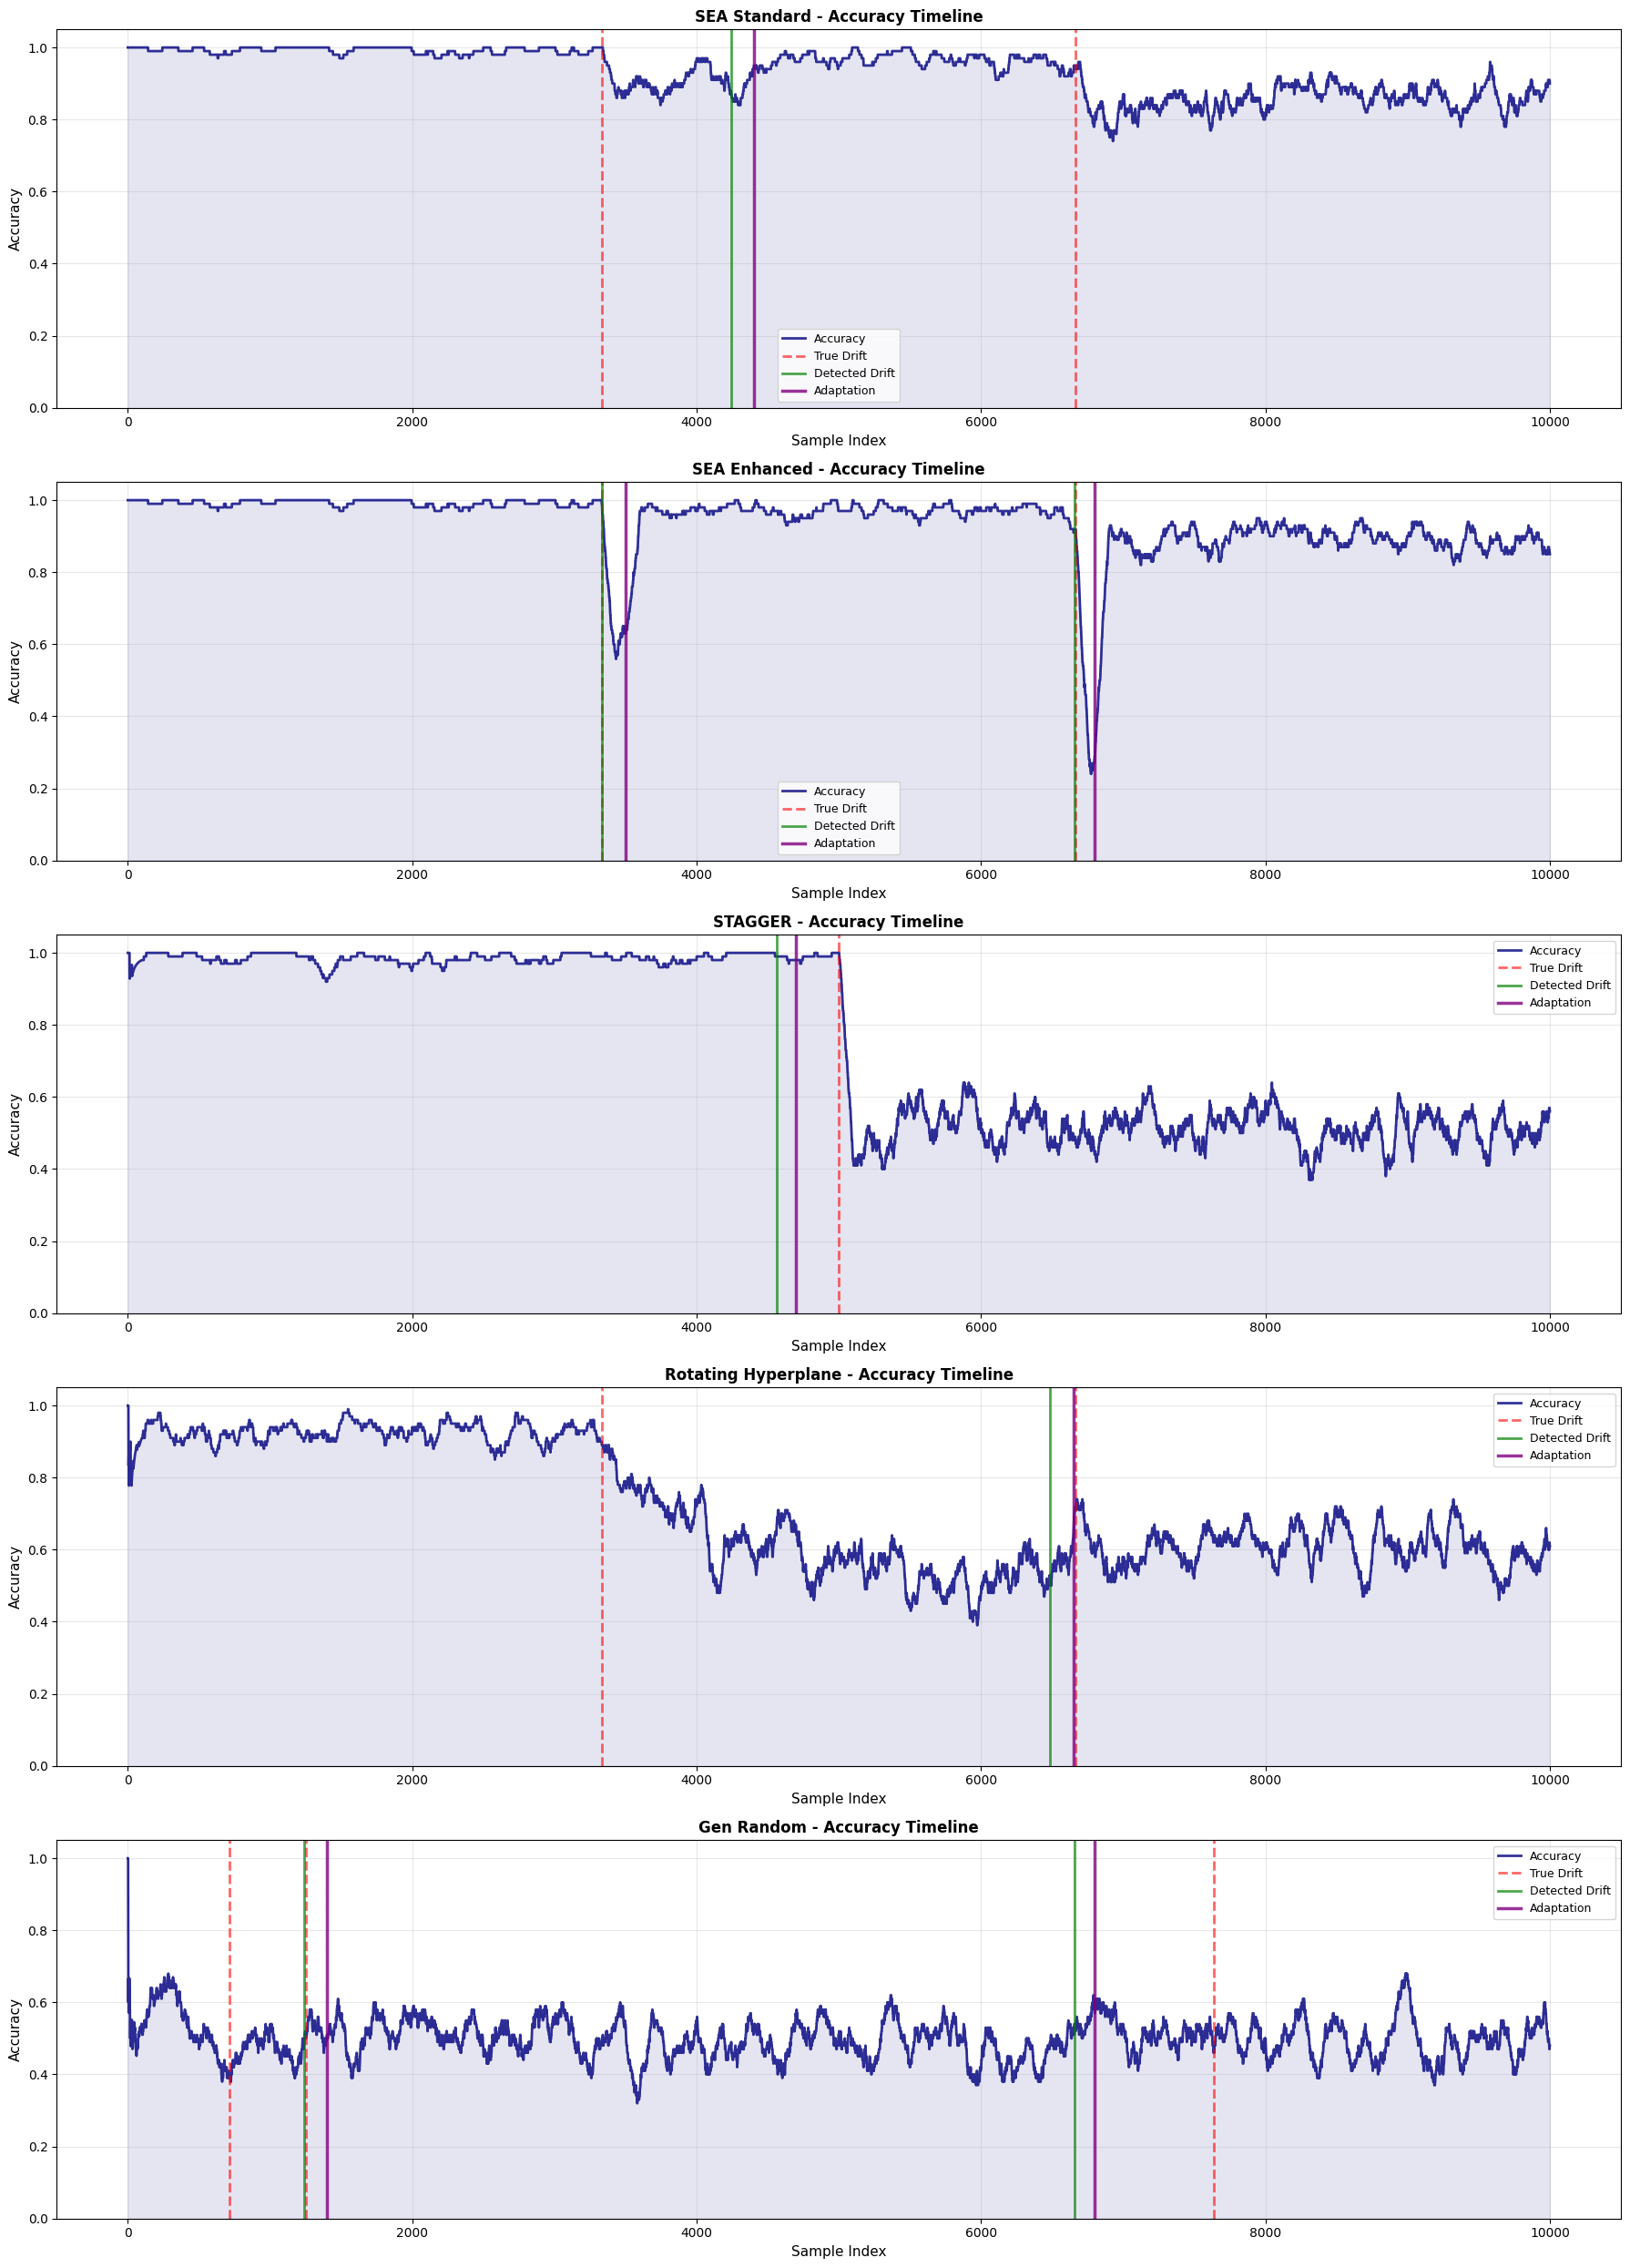

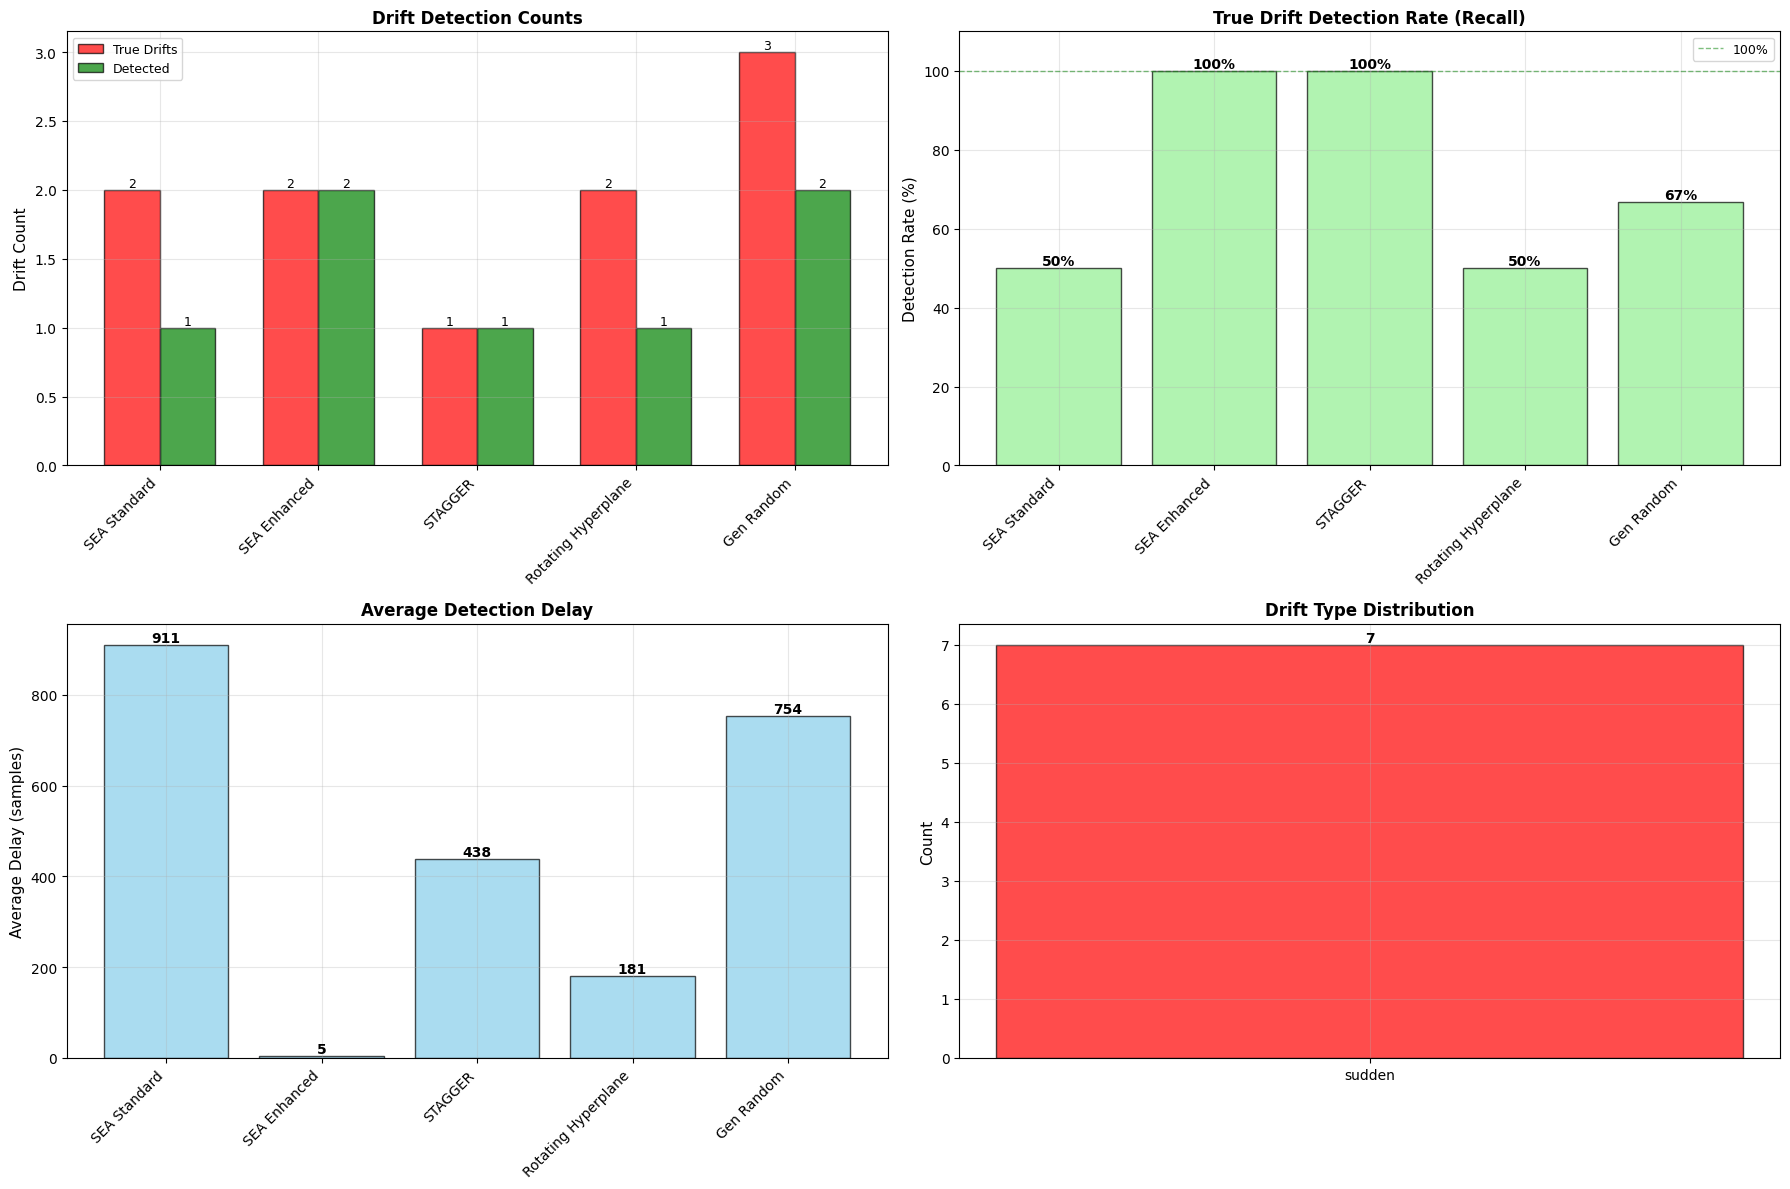

In [5]:
# COMPREHENSIVE VISUALIZATION

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    # Plot 1: Accuracy timeline for each dataset
    n_datasets = len(all_results)
    fig1, axes1 = plt.subplots(n_datasets, 1, figsize=(18, 5 * n_datasets))
    if n_datasets == 1:
        axes1 = [axes1]
    
    for ax_idx, result in enumerate(all_results):
        ax = axes1[ax_idx]
        
        # Accuracy timeline
        acc_indices = np.array([item['idx'] for item in result['accuracy_tracker']])
        acc_values = np.array([item['accuracy'] for item in result['accuracy_tracker']])
        
        ax.plot(acc_indices, acc_values, linewidth=2, color='navy', alpha=0.8, label='Accuracy')
        ax.fill_between(acc_indices, 0, acc_values, alpha=0.1, color='navy')
        
        # Mark true drift positions
        for true_drift in result['true_drift_positions']:
            ax.axvline(true_drift, color='red', linestyle='--', linewidth=2, alpha=0.6, 
                      label='True Drift' if true_drift == result['true_drift_positions'][0] else '')
        
        # Mark detected drifts
        for drift_det in result['drift_detected_list']:
            ax.axvline(drift_det['detected_at'], color='green', linestyle='-', linewidth=2, alpha=0.7, 
                      label='Detected Drift' if drift_det == result['drift_detected_list'][0] else '')
        
        # Mark adaptations
        for adapt in result['adaptation_events']:
            ax.axvline(adapt['idx'], color='purple', linestyle='-', linewidth=2.5, alpha=0.8, 
                      label='Adaptation' if adapt == result['adaptation_events'][0] else '')
        
        ax.set_xlabel('Sample Index', fontsize=11)
        ax.set_ylabel('Accuracy', fontsize=11)
        ax.set_title(f"{result['dataset_name']} - Accuracy Timeline", fontsize=12, fontweight='bold')
        ax.set_ylim([0, 1.05])
        ax.legend(loc='best', fontsize=9)
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Detection statistics
    fig2, ((ax2a, ax2b), (ax2c, ax2d)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot 2a: Detection counts
    dataset_names = [r['dataset_name'] for r in all_results]
    detected_counts = [len(r['drift_detected_list']) for r in all_results]
    true_counts = [len(r['true_drift_positions']) for r in all_results]
    
    x_pos = np.arange(len(dataset_names))
    width = 0.35
    
    bars1 = ax2a.bar(x_pos - width/2, true_counts, width, label='True Drifts', color='red', alpha=0.7, edgecolor='black')
    bars2 = ax2a.bar(x_pos + width/2, detected_counts, width, label='Detected', color='green', alpha=0.7, edgecolor='black')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2a.text(bar.get_x() + bar.get_width()/2., height,
                         f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    ax2a.set_xticks(x_pos)
    ax2a.set_xticklabels(dataset_names, rotation=45, ha='right')
    ax2a.set_ylabel('Drift Count', fontsize=11)
    ax2a.set_title('Drift Detection Counts', fontsize=12, fontweight='bold')
    ax2a.legend()
    ax2a.grid(axis='y', alpha=0.3)
    
    # Plot 2b: Detection rate
    detection_rates = []
    for result in all_results:
        matched = len(result['drift_detected_list'])
        total_true = len(result['true_drift_positions'])
        if total_true > 0:
            detection_rates.append((matched / total_true) * 100)
        else:
            detection_rates.append(0)
    
    bars = ax2b.bar(x_pos, detection_rates, color='lightgreen', alpha=0.7, edgecolor='black')
    
    for bar, rate in zip(bars, detection_rates):
        height = bar.get_height()
        ax2b.text(bar.get_x() + bar.get_width()/2., height,
                 f'{rate:.0f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax2b.set_xticks(x_pos)
    ax2b.set_xticklabels(dataset_names, rotation=45, ha='right')
    ax2b.set_ylabel('Detection Rate (%)', fontsize=11)
    ax2b.set_title('True Drift Detection Rate (Recall)', fontsize=12, fontweight='bold')
    ax2b.set_ylim([0, 110])
    ax2b.axhline(100, color='green', linestyle='--', linewidth=1, alpha=0.5, label='100%')
    ax2b.legend()
    ax2b.grid(axis='y', alpha=0.3)
    
    # Plot 2c: Average detection delay
    avg_delays = []
    for result in all_results:
        if len(result['drift_detected_list']) > 0:
            delays = [abs(d['delay']) for d in result['drift_detected_list']]
            avg_delays.append(np.mean(delays))
        else:
            avg_delays.append(0)
    
    bars = ax2c.bar(x_pos, avg_delays, color='skyblue', alpha=0.7, edgecolor='black')
    
    for bar, delay in zip(bars, avg_delays):
        height = bar.get_height()
        if height > 0:
            ax2c.text(bar.get_x() + bar.get_width()/2., height,
                     f'{delay:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax2c.set_xticks(x_pos)
    ax2c.set_xticklabels(dataset_names, rotation=45, ha='right')
    ax2c.set_ylabel('Average Delay (samples)', fontsize=11)
    ax2c.set_title('Average Detection Delay', fontsize=12, fontweight='bold')
    ax2c.grid(axis='y', alpha=0.3)
    
    # Plot 2d: Drift type distribution
    all_drift_types = []
    for result in all_results:
        for drift_det in result['drift_detected_list']:
            all_drift_types.append(drift_det['drift_type'])
    
    if len(all_drift_types) > 0:
        drift_type_counts = {}
        for dtype in all_drift_types:
            drift_type_counts[dtype] = drift_type_counts.get(dtype, 0) + 1
        
        types = list(drift_type_counts.keys())
        counts = list(drift_type_counts.values())
        
        colors = {'sudden': 'red', 'incremental': 'orange', 'gradual': 'yellow', 
                 'recurrent': 'blue', 'blip': 'gray'}
        bar_colors = [colors.get(t, 'lightblue') for t in types]
        
        bars = ax2d.bar(types, counts, color=bar_colors, alpha=0.7, edgecolor='black')
        
        for bar in bars:
            height = bar.get_height()
            ax2d.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax2d.set_ylabel('Count', fontsize=11)
        ax2d.set_title('Drift Type Distribution', fontsize=12, fontweight='bold')
        ax2d.grid(axis='y', alpha=0.3)
    else:
        ax2d.text(0.5, 0.5, 'No drift types detected', ha='center', va='center', 
                 transform=ax2d.transAxes, fontsize=12)
        ax2d.axis('off')
    
    plt.tight_layout()
    plt.show()
